In [1]:
#installing pmdarima library

#!pip install pmdarima

In [2]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6      #Width, height in inches.
import warnings # To ignore warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima import auto_arima
import itertools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

print("libraries imported successfully")

libraries imported successfully


In [3]:
# Loading data
gold_data = pd.read_csv("Monthly_Gold_Price_data.csv")#, index_col=[0],parse_dates=[0])

# first 5 rows of data
gold_data.head()

,Month,Price
0,31-12-1978,NaN
1,31-01-1979,649.3
2,28-02-1979,709.6
3,30-03-1979,684.4
4,30-04-1979,710.1


In [4]:
#Dropping Null values
gold_data = gold_data.dropna(axis=0)
gold_data.tail()

,Month,Price
504,31-12-2020,48650.7
505,29-01-2021,47966.6
506,26-02-2021,45176.6
507,31-03-2021,43612.4
508,30-04-2021,46185.7


In [5]:
#info of dataset
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 1 to 508
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   508 non-null    object 
 1   Price   508 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.9+ KB


In [6]:
#convert Month to datetime
gold_data['Month'] = pd.to_datetime(gold_data['Month'])

gold_data.head()

,Month,Price
1,1979-01-31,649.3
2,1979-02-28,709.6
3,1979-03-30,684.4
4,1979-04-30,710.1
5,1979-05-31,794.9


In [7]:
#setting month to index
gold_data.set_index('Month',inplace=True)

gold_data.head()

,Price
Month,
1979-01-31,649.3
1979-02-28,709.6
1979-03-30,684.4
1979-04-30,710.1
1979-05-31,794.9


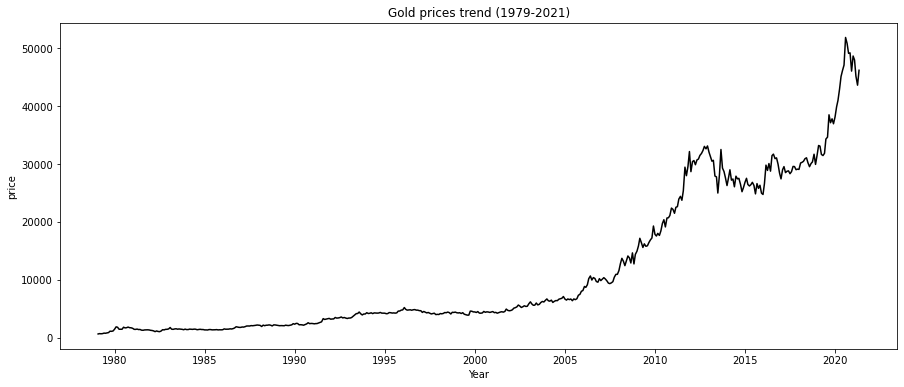

In [8]:
# plotting the graph of data
plt.xlabel("Year")
plt.ylabel("price")
plt.title("Gold prices trend (1979-2021)")
plt.plot(gold_data,color='black')

**From above figure we can see that our time series is not stationary. Also, Trend and Seasionality are present in the series. There is an increasing trend in the series, i.e. the gold prices are increasing w.r.t. time.**

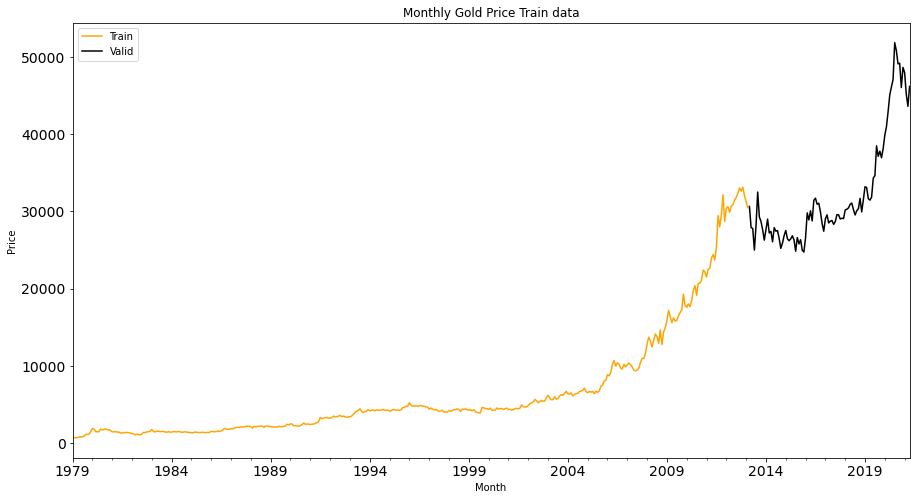

In [9]:
#splitting of dataset

train_gold_data = gold_data[:410]
valid_gold_data = gold_data[410:]

#plotting the time series train test data set

train_gold_data.Price.plot(figsize=(15,8), title = 'Monthly Gold Price Train data', fontsize=14, label = 'Train', color='orange')

#plotting the time series train test data set

valid_gold_data.Price.plot(figsize=(15,8), title = 'Monthly Gold Price Train data' , fontsize=14, label = 'Valid', color='Black')

plt.xlabel('Month')

plt.ylabel('Price')

plt.legend(loc='best')

plt.show()

#### Naive Forecasting

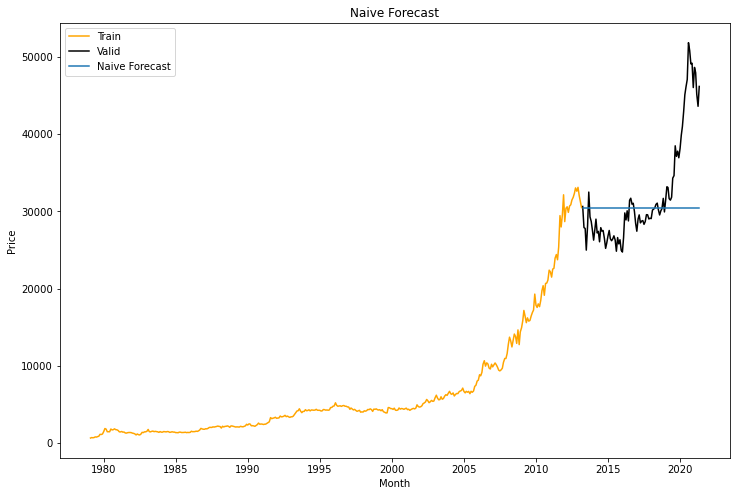

In [10]:
dd = np.asanyarray(train_gold_data.Price)

y_hat = valid_gold_data.copy()

y_hat['naive'] = dd[len(dd)-1]

plt.figure(figsize=(12,8))

plt.plot(train_gold_data.index, train_gold_data['Price'],label='Train',color='orange')

plt.plot(valid_gold_data.index, valid_gold_data['Price'],label='Valid',color='black')

plt.plot(y_hat.index, y_hat['naive'],label='Naive Forecast')

plt.legend(loc='best')

plt.title("Naive Forecast")

plt.xlabel("Month")

plt.ylabel("Price")

plt.show()

In [11]:
#Checking RMSE

rms = sqrt(mean_squared_error(valid_gold_data.Price, y_hat.naive))
print(f'Residual sum of square is {rms}')

Residual sum of square is 7161.324484033121


#### moving average forecast

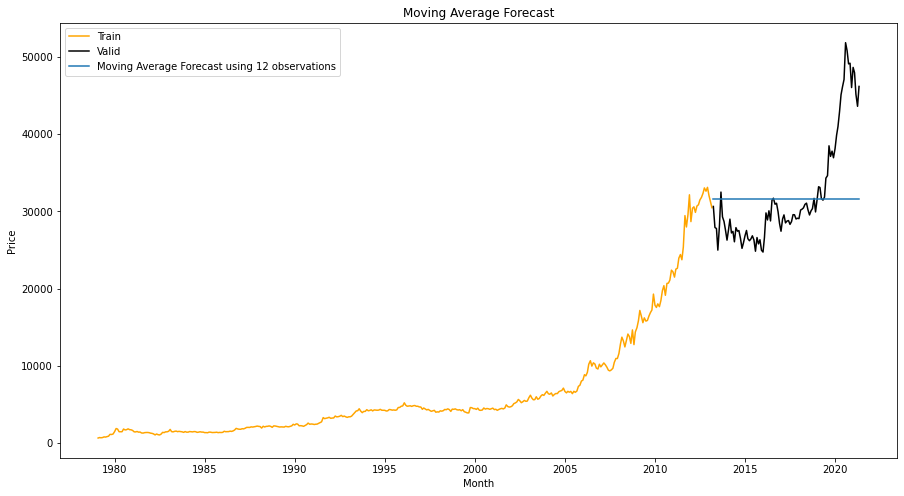

In [12]:
y_hat_avg = valid_gold_data.copy()

y_hat_avg['moving_avg_forecast'] = train_gold_data['Price'].rolling(12).mean().iloc[-1] #average of 12 obseervations

plt.figure(figsize=(15,8))

plt.plot(train_gold_data['Price'],label='Train',color='orange')

plt.plot(valid_gold_data['Price'],label='Valid',color='black')

plt.plot(y_hat_avg['moving_avg_forecast'],label='Moving Average Forecast using 12 observations')

plt.legend(loc='best')

plt.title("Moving Average Forecast")

plt.xlabel("Month")

plt.ylabel("Price")

plt.show()

In [13]:
#Checking RMSE

rms = sqrt(mean_squared_error(valid_gold_data.Price, y_hat_avg.moving_avg_forecast))
print(f'Residual sum of square is {rms}')

Residual sum of square is 6984.452739721776


We have to make sure that the TS is stationary. If the TS is not stationary, we'll make it stationary.

Stationarity check:
1) rolling statistics: Plot the moving average or moving variance and see if it varies with time. More of a visual technique.

2) Augmented diki-cooler test(ADCF) test:

* We use Dickey Fuller test to check the stationarity of the series.

* The intuition behind this is that it determines how strongly a TS is defined by trend.

* The null hypothesis of the test is the TS is not stationary (has some time-dependent strucuture).

* The alternate hypothesis(rejecting the null hypothesis) is that the TS is stationary.

* The test results comprise of a Test statistic & some critical values for difference confidence levels. If the 'Test statistic' is less than the 'Critical value',we can reject the null hypothesis & say that the series is stationary.

* We interpret this result using the Test statistic & critical value. If the Test Statistic is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test statistics suggests we accept the null hypothesis (non-stationary).

In [14]:
# defining function for checking stationarity

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #determining rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries,color = 'red',label='Original')
    mean = plt.plot(rolmean, color = 'blue', label = 'Rolling mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling sd') 
    plt.legend(loc = 'best')
    plt.title('Rolling mean & Standard deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    from statsmodels.tsa.stattools import adfuller

    print('Results of Dickey-Fuller test')
    dftest = adfuller(timeseries,autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test_statistic','p-value','#Lags_used','Number_of_observations_used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dfoutput[1] > 0.01:
        print("The time series data is not stationary")
    else:
        print("The time series data is stationary. Proceed for fitting of model")

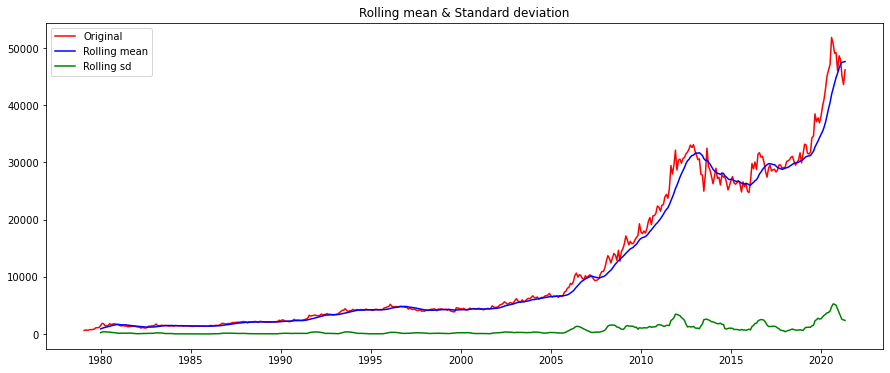

Results of Dickey-Fuller test
Test_statistic                   1.897364
p-value                          0.998524
#Lags_used                       8.000000
Number_of_observations_used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64
The time series data is not stationary


In [15]:
#testing stationarity of data

test_stationarity(gold_data)

From above graph we also see that the mean and standard deviation is not stationary. Also,from above result we have p value is greater than level of significance hence we accept the null hypothesis and we conclude that the time series is not stationary.

**Removing Trend**
A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear.

We can see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for ex: moving average transformation.

We will take rolling average here to remove the trend. We'll take the window size of 12 based on the 12 month

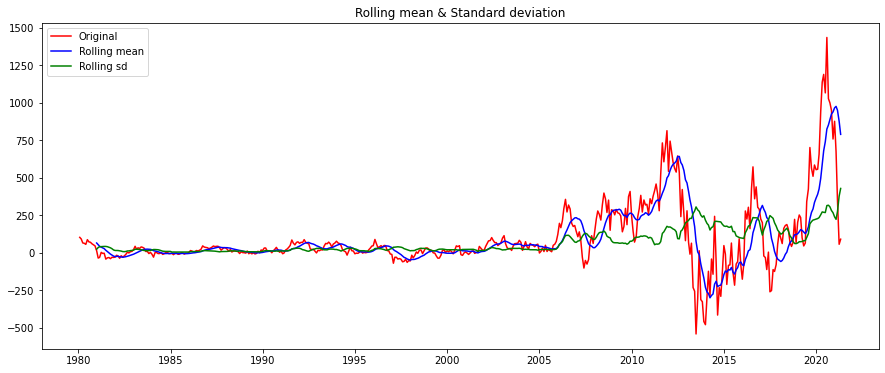

Results of Dickey-Fuller test
Test_statistic                  -3.693797
p-value                          0.004201
#Lags_used                      17.000000
Number_of_observations_used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64
The time series data is stationary. Proceed for fitting of model


In [16]:
#transforming data
gold_data_ma = gold_data.rolling(12).mean()
gold_data_log = np.log(gold_data)
gold_data_diff = gold_data_ma - gold_data_ma.shift(1)
gold_data_diff.dropna(inplace=True)

#checking stationarity
test_stationarity(gold_data_diff)

**ARIMA model:**

ARIMA stands for Auto Regression Integrated Moving Average. It is specified by 3 ordered parameters (p,d,q):

Here, p is the order of the autoregressive model (number of time lags) d is the degree of differencing (number of times the data have had past values subtracted) q is the order of moving average model.

The ARIMA forecasting for a stationary TS is nothing but a linear (like a linear regression) equation.

Autoregressive:A model that uses the dependent relationship between an observation and some number of lagged observations.

Integrated:The use of differencing of raw observations (e.g. subtracting an observation from observation at the previous time step) in order to make the time series stationary.

Moving Average: A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#plotting ACF
def plotting_acf(df,lags):
    plot_acf(df.dropna(),lags=lags)
    plt.show()

#plotting PACF
def plotting_pacf(df,lags):
    plot_pacf(df.dropna(),lags=lags)
    plt.show()

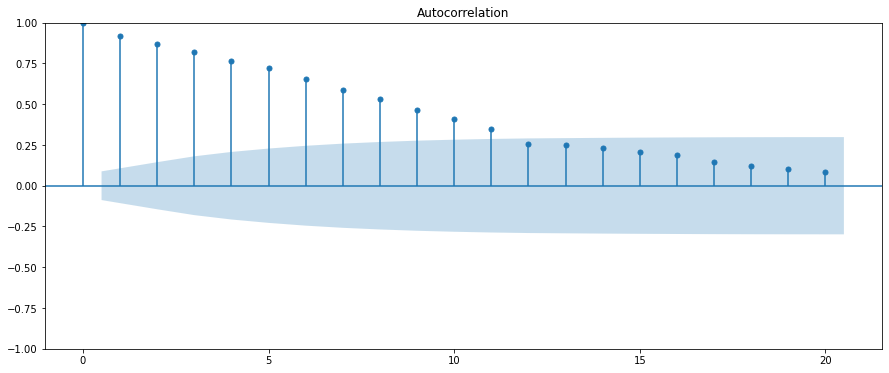

In [18]:
plotting_acf(gold_data_diff,20)

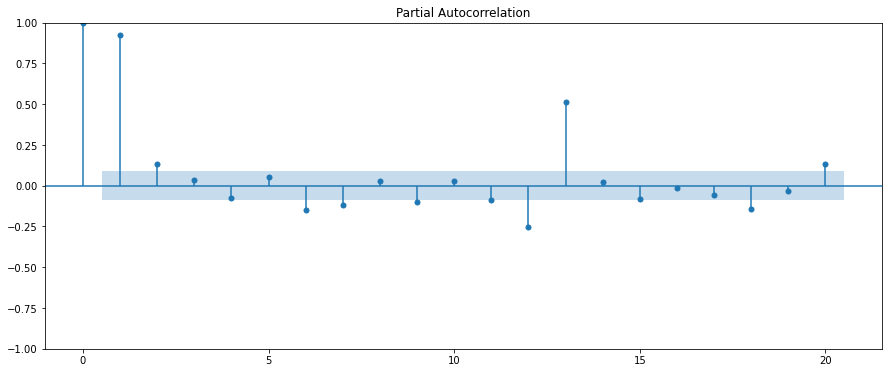

In [19]:
plotting_pacf(gold_data_diff,20)

In [20]:
# setting the values
p_values=range(0,5)
q_values=range(0,11)
d_values=range(0,2)

# To know the parameters of ARIMA model we use the following auto arima model:

def stepwise_fit_ARIMA(df):
    stepwise_fit = auto_arima(df.dropna(),
                          start_p=0,d=1,start_q=0,
                          max_p=5,max_q=7,
                          trace=True,suppress_warnings=True)

In [21]:
stepwise_fit_ARIMA(gold_data_diff)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5848.863, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5837.498, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5836.270, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5846.863, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5838.108, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5838.021, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5817.856, Time=1.03 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5781.585, Time=1.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5817.109, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5821.067, Time=1.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5819.258, Time=1.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5819.099, Time=1.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5

C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


plotting ARIMA model


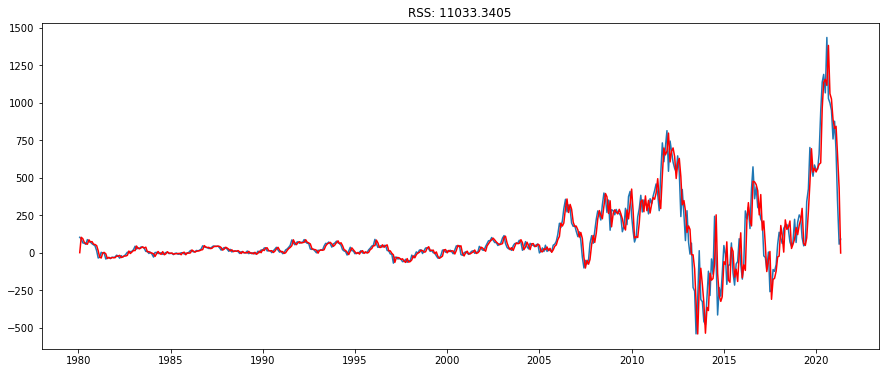

In [22]:
# fitting of ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#AR model
model = ARIMA(gold_data_diff.dropna(), order = (2,1,2))
results_ARIMA = model.fit()
plt.plot(gold_data_diff)
plt.plot(results_ARIMA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum(results_ARIMA.fittedvalues-gold_data_diff['Price'])**2)
print("plotting ARIMA model")

In [23]:
# Retranformation to actual values
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = ARIMA_diff_predictions.cumsum().shift().fillna(0)
print (predictions_ARIMA_diff_cumsum.tail())

Month
2020-12-31    43876.656513
2021-01-29    44704.955810
2021-02-26    45547.353342
2021-03-31    46207.338572
2021-04-30    46637.740144
dtype: float64


Text(0.5, 1.0, 'RMSE: 2390.0946')

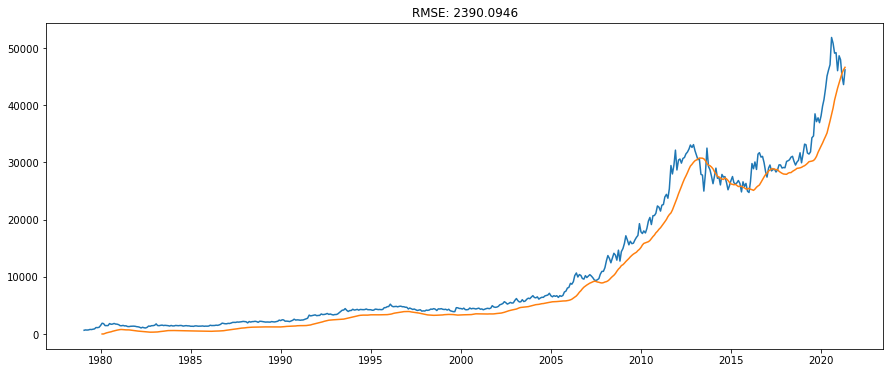

In [24]:
# plotting forecasted price
plt.plot(gold_data)
plt.plot(predictions_ARIMA_diff_cumsum)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_diff_cumsum-gold_data[12:]['Price'])**2)/len(gold_data)))

**What is SARIMA?**

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

**Trend Elements:**

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

p: Trend autoregression order.

d: Trend difference order.

q: Trend moving average order.

**Seasonal Elements:**

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

m: The number of time steps for a single seasonal period.

C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)


plotting SARIMA model


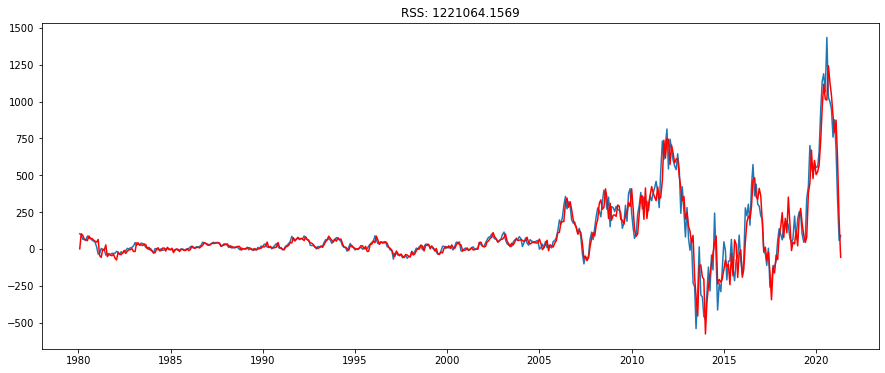

In [25]:
# importing library for SARIMA model
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(gold_data_diff.Price, trend='n', order=(0,1,2), seasonal_order=(1,1,1,12))
results_SARIMA = mod.fit()

plt.plot(gold_data_diff)
plt.plot(results_SARIMA.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum(results_SARIMA.fittedvalues-gold_data_diff['Price'])**2)
print("plotting SARIMA model")

In [26]:
# Retranformation to actual values
SARIMA_diff_predictions = pd.Series(results_SARIMA.fittedvalues, copy=True)
predictions_SARIMA_diff_cumsum = SARIMA_diff_predictions.cumsum().shift(1).fillna(0)
print (predictions_SARIMA_diff_cumsum.tail())

Month
2020-12-31    43213.919340
2021-01-29    44003.822817
2021-02-26    44876.446304
2021-03-31    45502.944082
2021-04-30    45692.824744
dtype: float64


Text(0.5, 1.0, 'RMSE: 2669.1917')

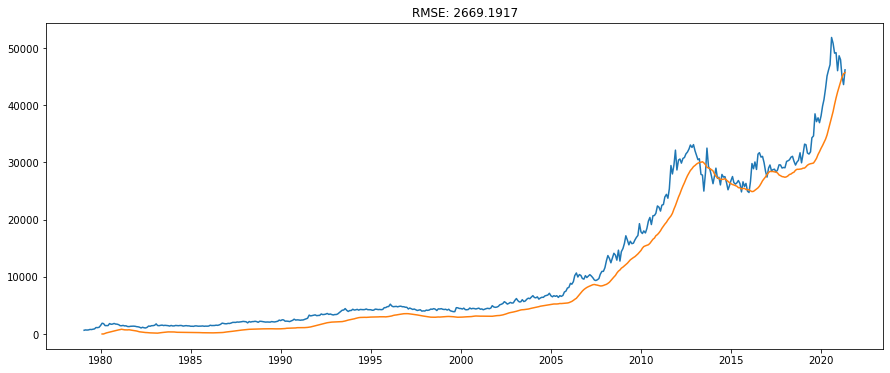

In [27]:
# plotting forecasted price
plt.plot(gold_data)
plt.plot(predictions_SARIMA_diff_cumsum)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_SARIMA_diff_cumsum-gold_data[12:]['Price'])**2)/len(gold_data)))

In [28]:
mod = sm.tsa.statespace.SARIMAX(gold_data_log.Price, trend='n', order=(0,1,2), seasonal_order=(1,1,1,12))
results_SARIMA = mod.fit()

C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
C:\Users\Shrinath\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)


In [29]:
forecasted_SARIMA = results_SARIMA.forecast(steps=60)
forecasted_SARIMA = np.exp(forecasted_SARIMA)
forecasted_SARIMA

2021-05-31    46584.458413
2021-06-30    46694.083893
2021-07-30    47119.123963
2021-08-31    48413.844368
2021-09-30    49166.990344
2021-10-29    48923.711396
2021-11-30    49525.783542
2021-12-31    49453.006839
2022-01-31    50680.306864
2022-02-28    51087.320073
2022-03-31    50499.922352
2022-04-29    50945.024402
2022-05-31    51480.871603
2022-06-30    51732.448356
2022-07-29    52322.406303
2022-08-31    53693.915503
2022-09-30    54458.437897
2022-10-31    54198.465350
2022-11-30    54753.270443
2022-12-30    54753.603766
2023-01-31    56055.835674
2023-02-28    56405.928918
2023-03-31    55722.936730
2023-04-28    56285.358854
2023-05-31    56874.605664
2023-06-30    57148.774897
2023-07-31    57797.064125
2023-08-31    59313.985745
2023-09-29    60160.568679
2023-10-31    59873.101804
2023-11-30    60489.226929
2023-12-29    60487.263840
2024-01-31    61927.493875
2024-02-29    62317.141823
2024-03-29    61563.566479
2024-04-30    62182.882285
2024-05-31    62833.949682
2

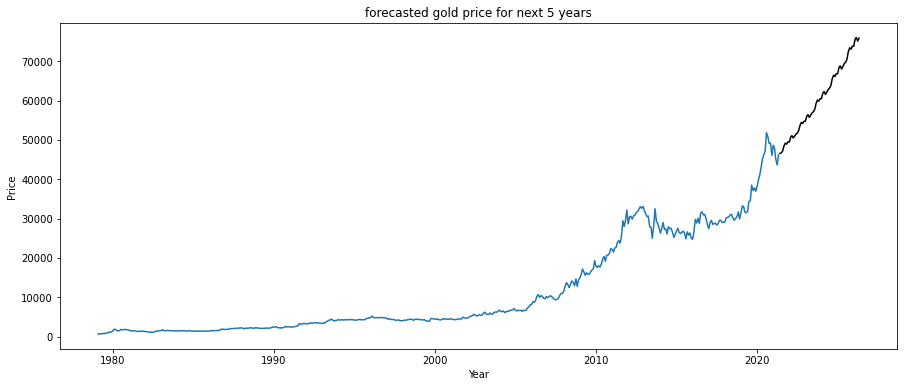

In [30]:
plt.plot(gold_data.Price)
plt.plot(forecasted_SARIMA,color='black')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("forecasted gold price for next 5 years")
plt.show()